In [1]:
%load_ext autoreload
%autoreload 2

import os
with open("api_key", 'r') as f:
    os.environ['OPENAI_API_KEY'] = f.readline()

import xml.etree.ElementTree as ET
from functools import partial

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

from vjp.openai_prompt import Prompt
from vjp import data, text

In [2]:
def clean_list_et(documents: list[ET.Element]):
    for doc in documents:
        doc: ET.Element = doc
        assert len(list(doc.iter('intro'))) <= 1, doc.attrib

    for doc in documents:
        doc: ET.Element = doc
        parent_map = {c: p for p in doc.iter() for c in p}
        intros = list(doc.iter('intro'))
        for i in intros:
            parent_map[i].remove(i)

In [3]:
upheld, rejected = data.load_second_instance_labeled()
clean_list_et(upheld)
clean_list_et(rejected)
df_all = data.shot_based_dataframe(upheld, rejected)
df_all[['preliminaries', 'decisions']] = \
    df_all[['preliminaries', 'decisions']].applymap(
        text.shot_normalize_whites_pipeline)
df_all.head()

,preliminaries,decisions,label
0,"Con sentenza in data DD/MM/2017, la Commission...",L'appello è fondato e va accolto.Preliminarmen...,1
1,Con l’avviso di accertamento n°877010100140 no...,Si premette che già nel PVC la Guardia di Fina...,1
2,L'Agenzia delle Entrate notificava alla societ...,"Osserva questa Commissione, con riguardo al pr...",1
3,"L'Agenzia delle Entrate Ufficio di Piacenza, c...",Osserva questo collegio che dalla lettura degl...,1
4,"Con rituale ricorso il signor LL, quale Ammini...",Questa Commissione rileva che non è controvers...,1


In [4]:
n_shot = 1
df_all_proc_len = df_all.sort_values(by="preliminaries", key=lambda x: x.str.len())

uphold_example = df_all_proc_len.loc[df_all['label'] == 1].head(n_shot)
rejected_example = df_all_proc_len.loc[df_all['label'] == 0].head(n_shot)

df_train = pd.concat([uphold_example, rejected_example])
df = df_all.drop(list(df_train.index[:]))

In [5]:
df.shape, df_all.shape, df_train.shape

((217, 3), (219, 3), (2, 3))

In [6]:
df_train

,preliminaries,decisions,label
34,ZG ha proposto ricorso avverso l’atto di conte...,MOTIVI DELLA DECISIONEL’appellante censura l’o...,1
191,L'agenzia delle Entrate di XXX propone appello...,"MOTIVI DELLA DECISIONE\nLa Commissione, letti ...",0


## Baselines

In [7]:
majority_baseline = DummyClassifier()
random_baseline = DummyClassifier(strategy='uniform', random_state=42)
baseline_X = np.expand_dims(df.preliminaries.to_numpy(), 1)
baseline_y = df.label.to_numpy()

In [8]:
# Fit and predict on the same data, it doesn't really matter here
majority_baseline.fit(baseline_X,
                      baseline_y)
majority_preds = majority_baseline.predict(baseline_X)
print(classification_report(baseline_y, majority_preds))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       127
           1       0.00      0.00      0.00        90

    accuracy                           0.59       217
   macro avg       0.29      0.50      0.37       217
weighted avg       0.34      0.59      0.43       217



c:\Users\micfae\AppData\Local\miniconda3\envs\vjp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\micfae\AppData\Local\miniconda3\envs\vjp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\micfae\AppData\Local\miniconda3\envs\vjp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [9]:
random_baseline.fit(baseline_X,
                      baseline_y)
random_preds = random_baseline.predict(baseline_X)
print(classification_report(baseline_y, random_preds))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57       127
           1       0.44      0.52      0.48        90

    accuracy                           0.53       217
   macro avg       0.53      0.53      0.53       217
weighted avg       0.54      0.53      0.53       217



## Prompts

In [10]:
verbalizer_ita = 'accolto', 'respinto'
template_ita = "Sei un sistema automatico per l'inferenza di decisioni giudiziarie in Italia. Hai in input un estratto del verbale d'appello. Rispondi con \"{}\" se è ritieni che l'appello debba essere accolto, con \"{}\" altrimenti. Rispondi con una sola parola. Il verbale:"

verbalizer_eng = 'upheld', 'rejected'
template_eng = "You are an automated system for inferring judicial decisions in Italy. You are given an excerpt from the appellate protocol as input. Respond with \"{}\" if you believe the appeal should be granted, or with \"{}\" otherwise. Respond with a single word. The excerpt:"

In [11]:
prompt_ita = Prompt(template_ita, verbalizer_ita, few_shot_data=df_train.to_dict('records'))
prompt_eng = Prompt(template_eng, verbalizer_eng, few_shot_data=df_train.to_dict('records'))

In [12]:
def compute_new_column(prompt, row, with_mot):
    message = prompt.create_prompt(row, with_mot)
    response = prompt.send_prompt(message)
    try:
        msg = prompt.interpret_response(response)
        return msg
    except:
        print(prompt.get_nice_prompt(message))
        print(response)
        return None

### Italian prompt

In [13]:
compute_new_column_no_mot = partial(compute_new_column, prompt_ita,
                                    with_mot=False)
# compute_new_column_mot = partial(compute_new_column, prompt_ita,
#                                  with_mot=True)

df['pred_label_no_mot'] = df.apply(compute_new_column_no_mot, axis=1)
# df['pred_label_mot'] = df.apply(compute_new_column_mot, axis=1)

Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Thu, 29 Jun 2023 13:03:45 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7dee577f1e8f0e59-MXP', 'alt-svc': 'h3=":443"; ma=86400'}


In [15]:
import pickle
with open('backup_cache_no_mot_correct_1_italian.pickle', 'wb') as f:
    pickle.dump(prompt_ita.cache, f)

In [20]:
df.to_pickle("backup_dataframe_no_mot_correct_1shot.pickle")

array([[<Axes: title={'center': 'pred_label_no_mot'}>]], dtype=object)

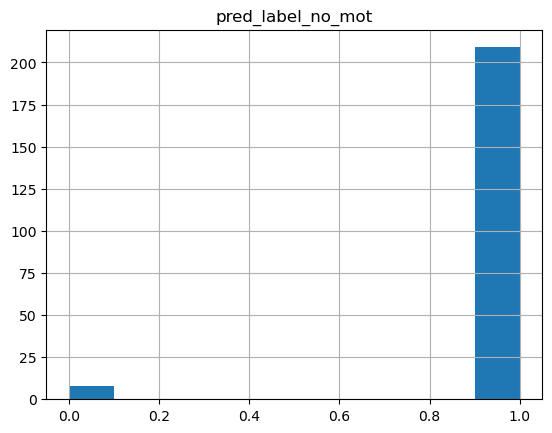

In [17]:
# df[['pred_label_no_mot', 'pred_label_mot']].hist()
df[['pred_label_no_mot']].hist()

In [18]:
# Substitute NaN values always with the wrong label (treat them like
# missclassification).
no_mot_nan_labels = df.pred_label_no_mot.isna()
# mot_nan_labels = df.pred_label_mot.isna()

df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[
    no_mot_nan_labels]
# df.pred_label_mot[mot_nan_labels] = 1 - df.label[mot_nan_labels]

# df.pred_label_mot = df.pred_label_mot.astype(np.int64)
df.pred_label_no_mot = df.pred_label_no_mot.astype(np.int64)

C:\Users\micfae\AppData\Local\Temp\ipykernel_4504\851119368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[


In [38]:
print(classification_report(df['label'], df['pred_label_no_mot']))
print(confusion_matrix(df['label'], df['pred_label_no_mot']))

              precision    recall  f1-score   support

           0       0.88      0.06      0.10       127
           1       0.43      0.99      0.60        90

    accuracy                           0.44       217
   macro avg       0.65      0.52      0.35       217
weighted avg       0.69      0.44      0.31       217

[[  7 120]
 [  1  89]]


In [41]:
# print(classification_report(df['label'], df['pred_label_mot']))
# print(confusion_matrix(df['label'], df['pred_label_mot']))

In [ ]:
for _, row in df.iterrows():
    message = prompt_ita.create_prompt(row)
    print(prompt_ita.get_nice_prompt(message))
    
    true = verbalizer_ita[1 - row['label']]
    pred = verbalizer_ita[1 - row['pred_label_no_mot']]

    print(f"True: {true} - Predicted: {pred}")

### English prompt

In [23]:
compute_new_column_no_mot = partial(compute_new_column, prompt_eng,
                                    with_mot=False)
# compute_new_column_mot = partial(compute_new_column, prompt_eng,
#                                  with_mot=True)

df['pred_label_no_mot'] = df.apply(compute_new_column_no_mot, axis=1)
# df['pred_label_mot'] = df.apply(compute_new_column_mot, axis=1)

The server is overloaded or not ready yet.
The server is overloaded or not ready yet.
The server is overloaded or not ready yet.
Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Thu, 29 Jun 2023 13:28:12 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7dee7b525aa00e59-MXP', 'alt-svc': 'h3=":443"; ma=86400'}


In [27]:
import pickle
with open('backup_cache_no_mot_correct_1_english.pickle', 'wb') as f:
    pickle.dump(prompt_eng.cache, f)

In [28]:
df.to_pickle('backup_dataframe_no_mot_correct_1shot_eng.pickle')

array([[<Axes: title={'center': 'pred_label_no_mot'}>]], dtype=object)

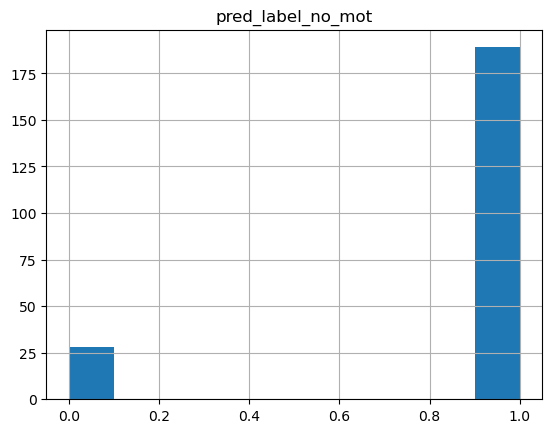

In [24]:
df[['pred_label_no_mot']].hist()

In [40]:
# df[['pred_label_no_mot', 'pred_label_mot']].hist()

In [32]:
# Substitute NaN values always with the wrong label (treat them like
# missclassification).
no_mot_nan_labels = df.pred_label_no_mot.isna()
# mot_nan_labels = df.pred_label_mot.isna()

df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[
    no_mot_nan_labels]
# df.pred_label_mot[mot_nan_labels] = 1 - df.label[mot_nan_labels]

# df.pred_label_mot = df.pred_label_mot.astype(np.int64)
df.pred_label_no_mot = df.pred_label_no_mot.astype(np.int64)

C:\Users\micfae\AppData\Local\Temp\ipykernel_4504\851119368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[


In [35]:
print(classification_report(df['label'], df['pred_label_no_mot']))
print(confusion_matrix(df['label'], df['pred_label_no_mot']))

              precision    recall  f1-score   support

           0       0.68      0.15      0.25       127
           1       0.43      0.90      0.58        90

    accuracy                           0.46       217
   macro avg       0.55      0.52      0.41       217
weighted avg       0.57      0.46      0.38       217

[[ 19 108]
 [  9  81]]


In [39]:
# print(classification_report(df['label'], df['pred_label_mot']))
# print(confusion_matrix(df['label'], df['pred_label_mot']))

In [ ]:
for _, row in df.iterrows():
    message = prompt_eng.create_prompt(row)
    print(prompt_eng.get_nice_prompt(message))
    
    true = verbalizer_eng[1 - row['label']]
    pred = verbalizer_eng[1 - row['pred_label_no_mot']]

    print(f"True: {true} - Predicted: {pred}")